In [12]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [14]:
#import
import numpy as np
import pandas as pd   # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화

In [20]:
# 데이터 생성 및 전처리(라벨인코딩만 하고, 원핫인코딩X)
from sklearn import datasets
iris = datasets.load_iris()
iris.keys()
iris_X = iris.data
iris_y = iris.target # 라벨인코딩이 되어 있음
iris_X.shape, iris_y.shape
train_X, test_X, train_y, test_y = train_test_split(iris_X, iris_y,
                                                   test_size=0.1,
                                                   stratify=iris_y,
                                                   random_state=4)

# 1. 기본적인 DNN(원핫인코딩X)

In [21]:
# 모델 설정
# model = Sequential()
# model.add(Input(4,))
# model.add(Dense(units=50, activation='relu'))
# model.add(Dense(units=30, activation='relu'))
# model.add(Dense(units=3, activation='softmax'))
model = Sequential([
    Input(4,),
    Dense(units=50, activation='relu'),
    Dense(units=30, activation='relu'),
    Dense(units=3, activation='softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                250       
                                                                 
 dense_7 (Dense)             (None, 30)                1530      
                                                                 
 dense_8 (Dense)             (None, 3)                 93        
                                                                 
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________


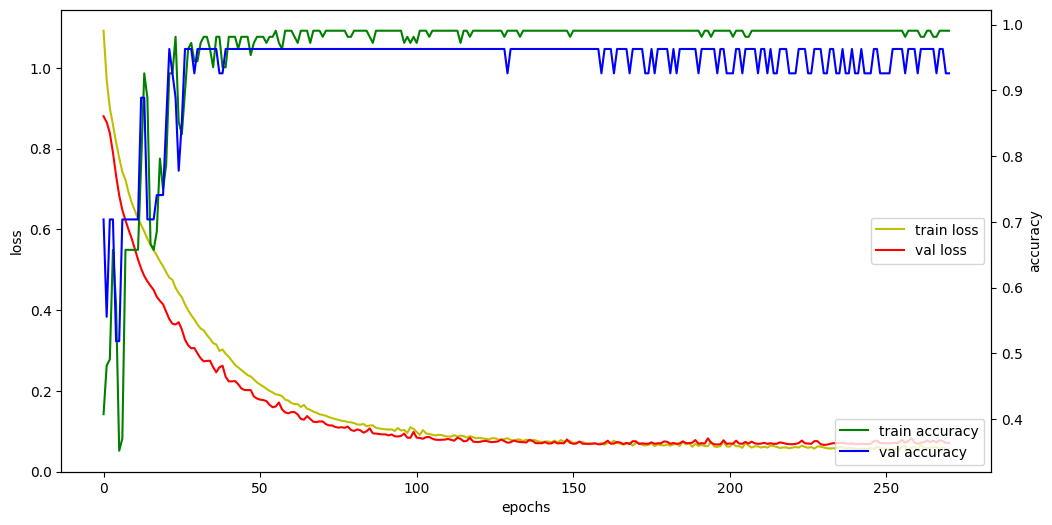

In [23]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

# 2. sklearn 이용
- 원핫인코딩을 하지 않고 라벨인코딩까지만 해야 작동. numpy 배열

In [25]:
from sklearn.neural_network import MLPClassifier

In [28]:
# 머신러닝 3장 교안 43page
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 30),
                     activation='relu',
                     solver='adam',
                     alpha=0.0001, # 과적합 방지 강도
                     batch_size=40,
                     max_iter=1000, # epoch
                     early_stopping=True, # 조기 종료 활성화(val_loss)
                     n_iter_no_change=50, # patience
                     warm_start=False, # True일 경우 이전학습에 이어서 학습
                     validation_fraction=0.1 # 검증셋 비율
                     )

In [30]:
mlp_model.fit(train_X, train_y)

MLPClassifier(batch_size=40, early_stopping=True, hidden_layer_sizes=(50, 30),
              max_iter=1000, n_iter_no_change=50)

In [36]:
# 모델 평가 : accuracy(test_X, test_y), recall, precision(test_X, yhat)
from sklearn.metrics import recall_score, precision_score
accuracy = mlp_model.score(test_X, test_y)
yhat = mlp_model.predict(test_X)
recall = recall_score(test_y, yhat, average='weighted')
precision = precision_score(test_y, yhat, average='weighted')
print('정확도 :', accuracy)
print('재현율 :', recall)
print('정밀도 :', precision)
print('교차표\n', pd.crosstab(test_y, yhat,
                          rownames=['실제'],
                          colnames=['예측']))

정확도 : 0.9333333333333333
재현율 : 0.9333333333333333
정밀도 : 0.9444444444444445
교차표
 예측  0  1  2
실제         
0   5  0  0
1   0  4  1
2   0  0  5


# 3. 클래스 이용

In [43]:
class DNNClassifier:
    @staticmethod
    def build(input_dim=4, activation='relu', optimizer='adam'):
        # 모델 구성
#         model = Sequential()
#         model.add(Input(input_dim,))
#         model.add(Dense(50, activation=activation))
#         model.add(Dense(30, activation=activation))
#         model.add(Dense(3, activation='softmax'))
        model = Sequential([
            Input(input_dim,),
            Dense(50, activation=activation),
            Dense(30, activation=activation),
            Dense(3, activation='softmax')
        ])
        # 모델 학습 설정
        model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
        return model

In [44]:
# 모델
model = DNNClassifier.build()
model.summary()
# 모델 학습
hist = model.fit(train_X, train_y,
                epochs=500,
                validation_split=0.2,
                verbose=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                250       
                                                                 
 dense_22 (Dense)            (None, 30)                1530      
                                                                 
 dense_23 (Dense)            (None, 3)                 93        
                                                                 
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________


# 4. 함수형 API 이용하기
- 병렬처리 : 속도 높이려고
- 레지듀얼블록(Residual block) : 모델의 성능을 높이려고 (자연어처리, 이미지처리)

In [46]:
#import
import numpy as np
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출)
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, add # add 레지듀얼블록
from tensorflow.keras.layers import concatenate # 병렬처리시 

In [50]:
# 데이터 생성 및 전처리(라벨인코딩만 하고, 원핫인코딩X)
from sklearn import datasets
iris = datasets.load_iris()
# iris.keys()
iris_X = iris.data
iris_y = iris.target # 라벨인코딩이 되어 있음
iris_X.shape, iris_y.shape
train_X, test_X, train_y, test_y = train_test_split(iris_X, iris_y,
                                                   test_size=0.1,
                                                   stratify=iris_y,
                                                   random_state=4)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((135, 4), (135,), (15, 4), (15,))

In [56]:
# 기존의 model 스타일 4 -> 50 -> 30 -> 3
input_ = Input(shape=(4,))
dense1 = Dense(units=50, activation='relu')(input_)
dense2 = Dense(units=30, activation='relu')(dense1)
dense3 = Dense(units=3, activation='softmax')(dense2)
model = Model(inputs=input_, outputs=dense3)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.fit(train_X, train_y, epochs=20,
         validation_split=0.2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_37 (Dense)            (None, 50)                250       
                                                                 
 dense_38 (Dense)            (None, 50)                2550      
                                                                 
 dense_39 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,953
Trainable params: 2,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 0s 54ms/step - loss: 1.2339 - accuracy: 0.3611 - val_loss: 1.2079 - val_accuracy: 0.2222
Epoch 2/20
4/4 [==============================] - 

In [63]:
# 병렬처리
# 4 -> 160(50,80,30로 병렬처리) -> 32 -> 3
input_ = Input(shape=(4,))
dense1 = Dense(units=50, activation='relu')(input_)
dense2 = Dense(units=80, activation='relu')(input_)
dense3 = Dense(units=30, activation='relu')(input_)
x = concatenate([dense1, dense2, dense3])
# x = Dense(160, activation='relu')(input_)의 병렬처리
dense4 = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(dense4)
model = Model(inputs=input_, outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 dense_57 (Dense)               (None, 50)           250         ['input_21[0][0]']               
                                                                                                  
 dense_58 (Dense)               (None, 80)           400         ['input_21[0][0]']               
                                                                                                  
 dense_59 (Dense)               (None, 30)           150         ['input_21[0][0]']               
                                                                                            

In [65]:
# 레지듀얼블록(Residual Block):딥러닝에서 딥한 네트워크가 학습이 잘 되지 않을 때
# 4 -> 50 -> 128 -> 50 -> (레지듀얼) -> 3
input_ = Input(shape=(4,))
dense1 = Dense(50, activation='relu')(input_)
dense2 = Dense(50, activation='relu')(dense1)
dense3 = add([dense1, dense2])
output = Dense(3, activation='softmax')(dense3)
model = Model(inputs=input_, outputs= output)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.fit(train_X, train_y, epochs=500,
         validation_split=0.2, verbose=0)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 dense_65 (Dense)               (None, 50)           250         ['input_23[0][0]']               
                                                                                                  
 dense_66 (Dense)               (None, 50)           2550        ['dense_65[0][0]']               
                                                                                                  
 add_1 (Add)                    (None, 50)           0           ['dense_65[0][0]',               
                                                                  'dense_66[0][0]']         

In [66]:
model.evaluate(test_X, test_y)

1/1 [==============================] - 0s 21ms/step - loss: 0.0197 - accuracy: 1.0000


[0.01968279294669628, 1.0]